
This Notebook will
+ Query video-game articles and associated genre from Wikipedia
+ Select genres with more than a chosen amount of instances
+ Extract monthly count-views for each genre, via the Wikipedia API
+ Save the obtained data in the file `video_game_genre2020`
+ Plot values


In [1]:
#useful imports
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
from urllib.request import urlopen
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

Let's extract all video-games as well as their genre from Wikipedia

In [2]:
sparql.setQuery("""
    PREFIX bd: <http://www.bigdata.com/rdf#>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX wikibase: <http://wikiba.se/ontology#>

select  ?objet ?objectLabel ?genreLabel ?url
where {
    ?object wdt:P31 wd:Q7889.
    ?object wdt:P136 ?genre.

    SERVICE wikibase:label {
      bd:serviceParam wikibase:language "en" .
    }
}
""")
sparql.setReturnFormat(JSON)
games_result = sparql.query().convert()

In [3]:
game_genre_df = pd.json_normalize(games_result['results']['bindings'])
game_genre_df

,objectLabel.xml:lang,objectLabel.type,objectLabel.value,genreLabel.xml:lang,genreLabel.type,genreLabel.value
0,en,literal,Civilization III,en,literal,strategy video game
1,en,literal,Civilization III,en,literal,4X
2,en,literal,Civilization III,en,literal,simulation video game
3,en,literal,Civilization III,en,literal,turn-based strategy video game
4,en,literal,Civilization III,en,literal,grand strategy wargame
...,...,...,...,...,...,...
48488,en,literal,Murder in Tehran's Alleys 2016,en,literal,indie game
48489,en,literal,Murder Mystery Adventure,en,literal,indie game
48490,en,literal,Vzerthos: The Heir of Thunder,en,literal,shooter game
48491,en,literal,Mutant Mudds Super Challenge,en,literal,platform game


If we count the number of unique genres, we can see there is a lot

In [4]:
unique_game_genre_df = game_genre_df['genreLabel.value'].unique()
unique_game_genre_df

array(['strategy video game', '4X', 'simulation video game',
       'turn-based strategy video game', 'grand strategy wargame',
       'real-time tactics', 'multiple perspectives role-playing',
       'tactical role-playing game', 'racing video game', 'indie game',
       'puzzle-platformer', 'action game', 'platform game',
       'action-adventure game', 'third-person shooter', 'stealth game',
       'shooter game', 'real-time strategy', 'first-person shooter',
       'card game video game', 'fantasy video game',
       'science fiction video game', 'fantasy', "shoot 'em up",
       'psychological horror', 'adventure game',
       'massively multiplayer online role-playing game',
       'action role-playing game', "beat 'em up", 'visual novel', 'harem',
       'eroge', 'school anime and manga', 'drama anime and manga',
       'romance anime and manga', 'sim racing', 'life simulation game',
       'massively multiplayer online real-time strategy game',
       'Christmas video game', 'p

We will consider here that categories with less than 1000 games are not relevant

In [5]:
test = game_genre_df.groupby(['genreLabel.value'])['objectLabel.value'].count()
irr = test[test.values<1000].index
test

genreLabel.value
2D computer graphics              9
3D computer graphics              7
3D computer graphics software     1
3D video game                     3
4X                               58
                                 ..
yaoi game                        62
yuri                              6
yuri game                        38
zombie apocalyptic fiction        4
zombie video game                 3
Name: objectLabel.value, Length: 692, dtype: int64

Once the genres are chosen, we format the article names to enable the research later on

In [6]:
game_genre_df = game_genre_df.drop(game_genre_df[game_genre_df['genreLabel.value'].isin(irr)].index)
game_genre_df = game_genre_df.replace(' – ', '', regex=True)
game_genre_df = game_genre_df.replace('°', '', regex=True)
game_genre_df = game_genre_df.replace(' ', '_', regex=True)
game_genre_df = game_genre_df.replace('/', '_', regex=True)

In [7]:
unique_game_genre_df = game_genre_df['genreLabel.value'].unique()
unique_game_genre_df

array(['racing_video_game', 'indie_game', 'action_game', 'platform_game',
       'action-adventure_game', 'first-person_shooter',
       'science_fiction_video_game', "shoot_'em_up", 'adventure_game',
       'visual_novel', 'role-playing_video_game', 'sports_video_game',
       'puzzle_video_game'], dtype=object)

We can now extract the monthly count-views

In [8]:
def get_monthly_count(code, name, start_date,end_date):
    '''
    Will return a dataframe of the monthly count-views of an article for the period given and a chosen language
    '''

    url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{}.wikipedia/all-access/all-agents/{}/monthly/{}/{}'.format(code,name,start_date,end_date)
    response = urlopen(url)
    data_json = json.loads(response.read())
    df =  pd.json_normalize(data_json['items'])
    return df


Here is an example to extract for the action genre

In [39]:
names = game_genre_df[game_genre_df['genreLabel.value']==unique_game_genre_df[0]]['objectLabel.value']


monthly_views_action = np.zeros(12)
for n in names:
    try:
        df = get_monthly_count('en',n,'2020010100','2020123100')
        df=df.replace(np.nan, 0)
        views = (df.views).array
        monthly_views_action+=views
    except:
        pass


In [25]:
df_action = get_monthly_count('en','Hitman:_Blood_Money','2020010100','2020123100')
df_action.views = monthly_views_action
df_action.article = 'action_games'
df_action

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,action_games,monthly,2020010100,all-access,all-agents,0.0
1,en.wikipedia,action_games,monthly,2020020100,all-access,all-agents,0.0
2,en.wikipedia,action_games,monthly,2020030100,all-access,all-agents,0.0
3,en.wikipedia,action_games,monthly,2020040100,all-access,all-agents,0.0
4,en.wikipedia,action_games,monthly,2020050100,all-access,all-agents,0.0
5,en.wikipedia,action_games,monthly,2020060100,all-access,all-agents,0.0
6,en.wikipedia,action_games,monthly,2020070100,all-access,all-agents,0.0
7,en.wikipedia,action_games,monthly,2020080100,all-access,all-agents,0.0
8,en.wikipedia,action_games,monthly,2020090100,all-access,all-agents,0.0
9,en.wikipedia,action_games,monthly,2020100100,all-access,all-agents,0.0


In [26]:
dates = df_action.timestamp.tolist()
date = []
for d in dates:
    date.append(datetime.strptime(d, '%Y%m%d%H').strftime('%d/%m/%Y'))
date

['01/01/2020',
 '01/02/2020',
 '01/03/2020',
 '01/04/2020',
 '01/05/2020',
 '01/06/2020',
 '01/07/2020',
 '01/08/2020',
 '01/09/2020',
 '01/10/2020',
 '01/11/2020',
 '01/12/2020']

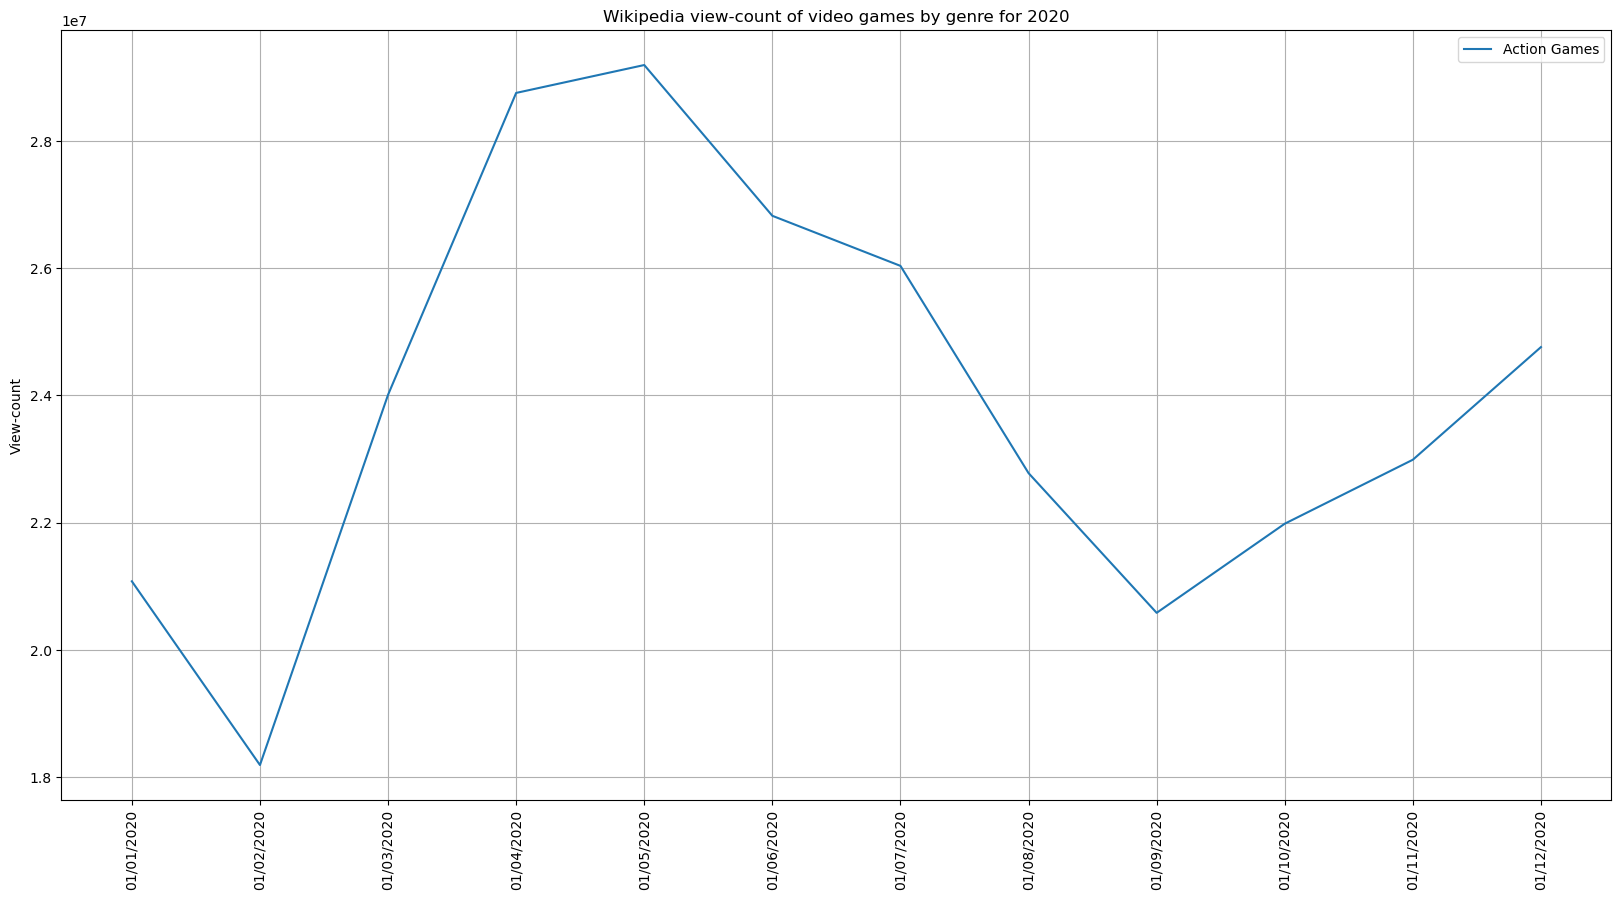

In [76]:
plt.figure(figsize=(20,10))
plt.plot(dates, df_action.views, label="Action Games")
plt.tick_params(axis='x', labelrotation=90)
plt.legend()
plt.grid()
plt.title("Wikipedia view-count of video games by genre for 2020")
plt.ylabel("View-count")
plt.xticks(dates, date)
plt.show()

Now let's compute it for all genres

In [113]:
monthly_views = np.zeros([12,1])

for g in range(len(unique_game_genre_df)):
    names = game_genre_df[game_genre_df['genreLabel.value']==unique_game_genre_df[g]]['objectLabel.value']
    monthly_views_genre = np.zeros([12,1])
    for n in names:
        try:
            df = get_monthly_count('en',n,'2020010100','2020123100')
            df=df.replace(np.nan, 0)
            views = (df.views).array
            views = np.reshape(views,[12,1])
            monthly_views_genre+=views
        except:
            pass
    monthly_views= np.append(monthly_views,monthly_views_genre,axis=1)


In [116]:
final = monthly_views[:,1:]
final

array([[21078112.,  3833782., 15776816., 12823771.,  6020084.,  6216997.,
         9603059.,  8285176.,  7232328.,  8470426.,  2637285.,  1716803.,
         8174650.],
       [18190465.,  3421738., 13500198., 10997641.,  5130817.,  5224861.,
         7967089.,  7316372.,  6275402.,  7967675.,  2615409.,  1508233.,
         7294164.],
       [24009540.,  3995808., 15503313., 12918494.,  5725841.,  6277233.,
         8987768.,  8620368.,  7656922., 12020184.,  2487448.,  1649490.,
         8463341.],
       [28754027.,  5080050., 18867462., 14938802.,  6800182.,  7095543.,
        10881668., 12486837., 10079612., 12347584.,  2580062.,  2003494.,
         9597789.],
       [29192449.,  4878953., 19012650., 14803330.,  6341135.,  6954233.,
        10238870.,  9989282.,  8761926., 10715658.,  2803942.,  1979320.,
         8794859.],
       [26822763.,  4366440., 18601378., 13585118.,  5710849.,  5801535.,
         8750638.,  8197269.,  7826553.,  9596858.,  2173187.,  1749472.,
         789

In [121]:
df = pd.DataFrame(final, columns = unique_game_genre_df)
df

,action-adventure_game,racing_video_game,action_game,platform_game,puzzle_video_game,shoot_'em_up,adventure_game,role-playing_video_game,science_fiction_video_game,first-person_shooter,sports_video_game,visual_novel,indie_game
0,21078112.0,3833782.0,15776816.0,12823771.0,6020084.0,6216997.0,9603059.0,8285176.0,7232328.0,8470426.0,2637285.0,1716803.0,8174650.0
1,18190465.0,3421738.0,13500198.0,10997641.0,5130817.0,5224861.0,7967089.0,7316372.0,6275402.0,7967675.0,2615409.0,1508233.0,7294164.0
2,24009540.0,3995808.0,15503313.0,12918494.0,5725841.0,6277233.0,8987768.0,8620368.0,7656922.0,12020184.0,2487448.0,1649490.0,8463341.0
3,28754027.0,5080050.0,18867462.0,14938802.0,6800182.0,7095543.0,10881668.0,12486837.0,10079612.0,12347584.0,2580062.0,2003494.0,9597789.0
4,29192449.0,4878953.0,19012650.0,14803330.0,6341135.0,6954233.0,10238870.0,9989282.0,8761926.0,10715658.0,2803942.0,1979320.0,8794859.0
5,26822763.0,4366440.0,18601378.0,13585118.0,5710849.0,5801535.0,8750638.0,8197269.0,7826553.0,9596858.0,2173187.0,1749472.0,7898191.0
6,26035727.0,4520226.0,17532955.0,12947686.0,5722555.0,5604261.0,8769576.0,8536129.0,8410041.0,9920604.0,2011030.0,1814625.0,8058429.0
7,22778474.0,4320648.0,17164159.0,12820903.0,5502462.0,5710996.0,9169583.0,8042394.0,7662405.0,9135845.0,2229137.0,1762851.0,7830251.0
8,20582481.0,3792122.0,16342440.0,12974898.0,5461093.0,5514770.0,8627906.0,8277071.0,7150526.0,8497364.0,2335745.0,1687760.0,7819359.0
9,21983329.0,4093456.0,18250453.0,14007596.0,6218358.0,5902024.0,9468653.0,9250358.0,7743378.0,8695642.0,2239131.0,1889840.0,8756388.0


Now that we have the dataframe, we save it as csv file

In [119]:
df.to_csv('video_game_genre2020.csv')

Finally, let's plot what we found

In [28]:
games= pd.read_csv('data/video_game_genre2020.csv')
count = game_genre_df.groupby(['genreLabel.value'])['objectLabel.value'].count()

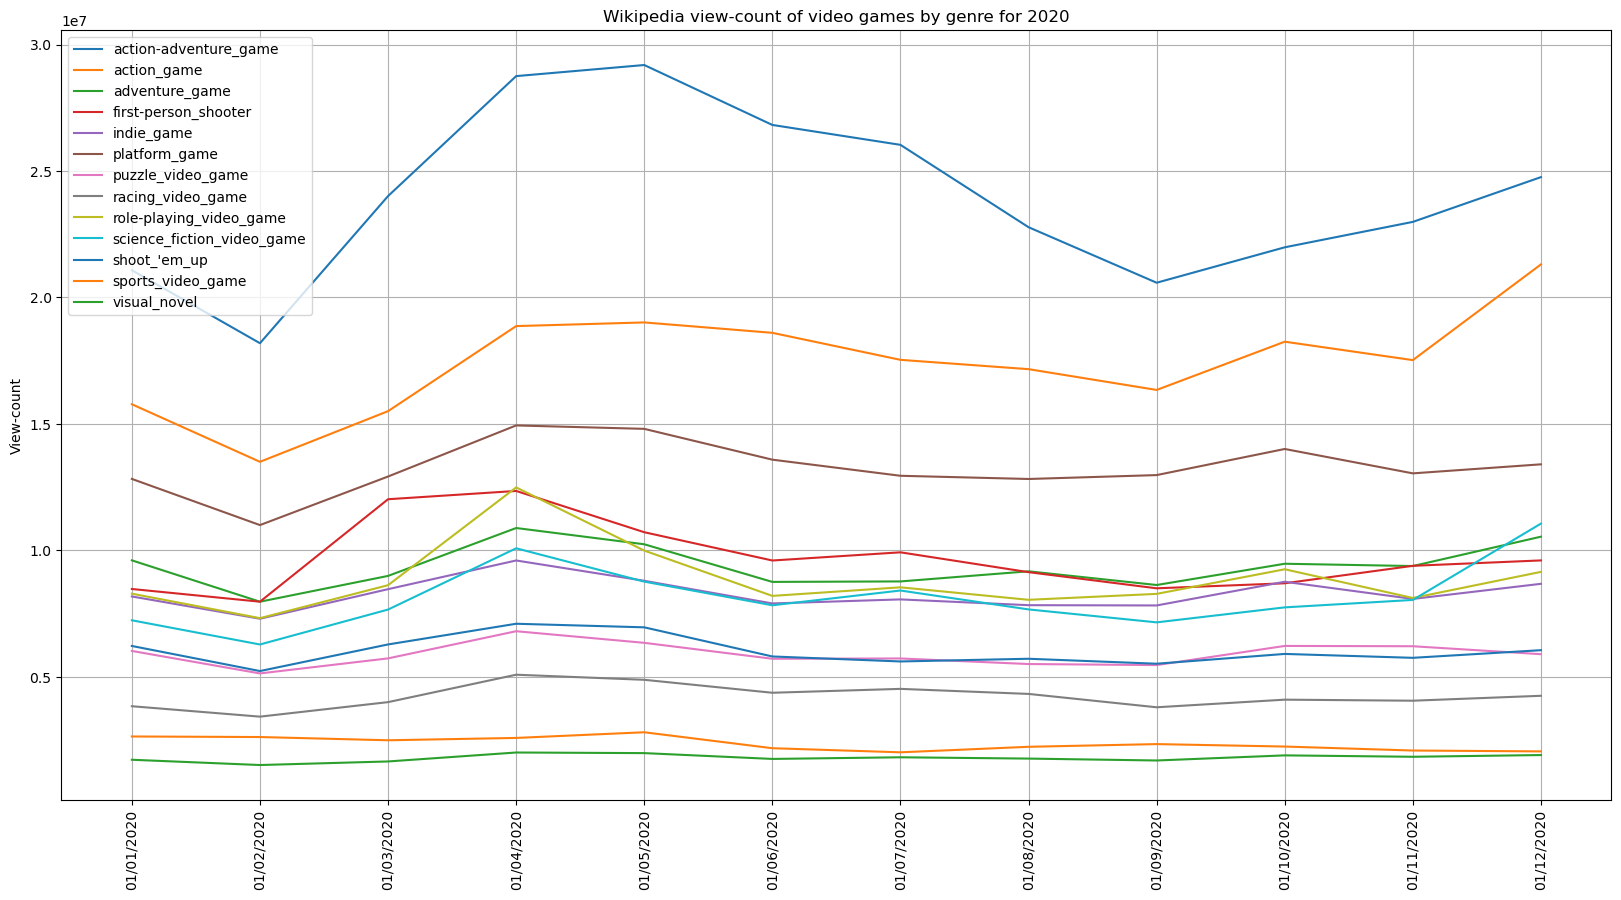

In [29]:
plt.figure(figsize=(20,10))
for g in count.index:
    plt.plot(dates, games['{}'.format(g)], label='{}'.format(g))

plt.tick_params(axis='x', labelrotation=90)
plt.legend()
plt.grid()
plt.title("Wikipedia view-count of video games by genre for 2020")
plt.ylabel("View-count")
plt.xticks(dates, date)
plt.show()

These were absolute view-counts, let's see relative view-counts taking into consideration the amount of articles per genre.

In [39]:
games= pd.read_csv('data/video_game_genre2020.csv')
count = game_genre_df.groupby(['genreLabel.value'])['objectLabel.value'].count()
count

genreLabel.value
action-adventure_game         1765
action_game                   3162
adventure_game                2054
first-person_shooter          1331
indie_game                    4650
platform_game                 2105
puzzle_video_game             2148
racing_video_game             1813
role-playing_video_game       2125
science_fiction_video_game    1306
shoot_'em_up                  1339
sports_video_game             1157
visual_novel                  1621
Name: objectLabel.value, dtype: int64

In [40]:
for g in count.index:
    games['{}'.format(g)] = games['{}'.format(g)].apply(lambda x: x/count['{}'.format(g)])

games_relative = games

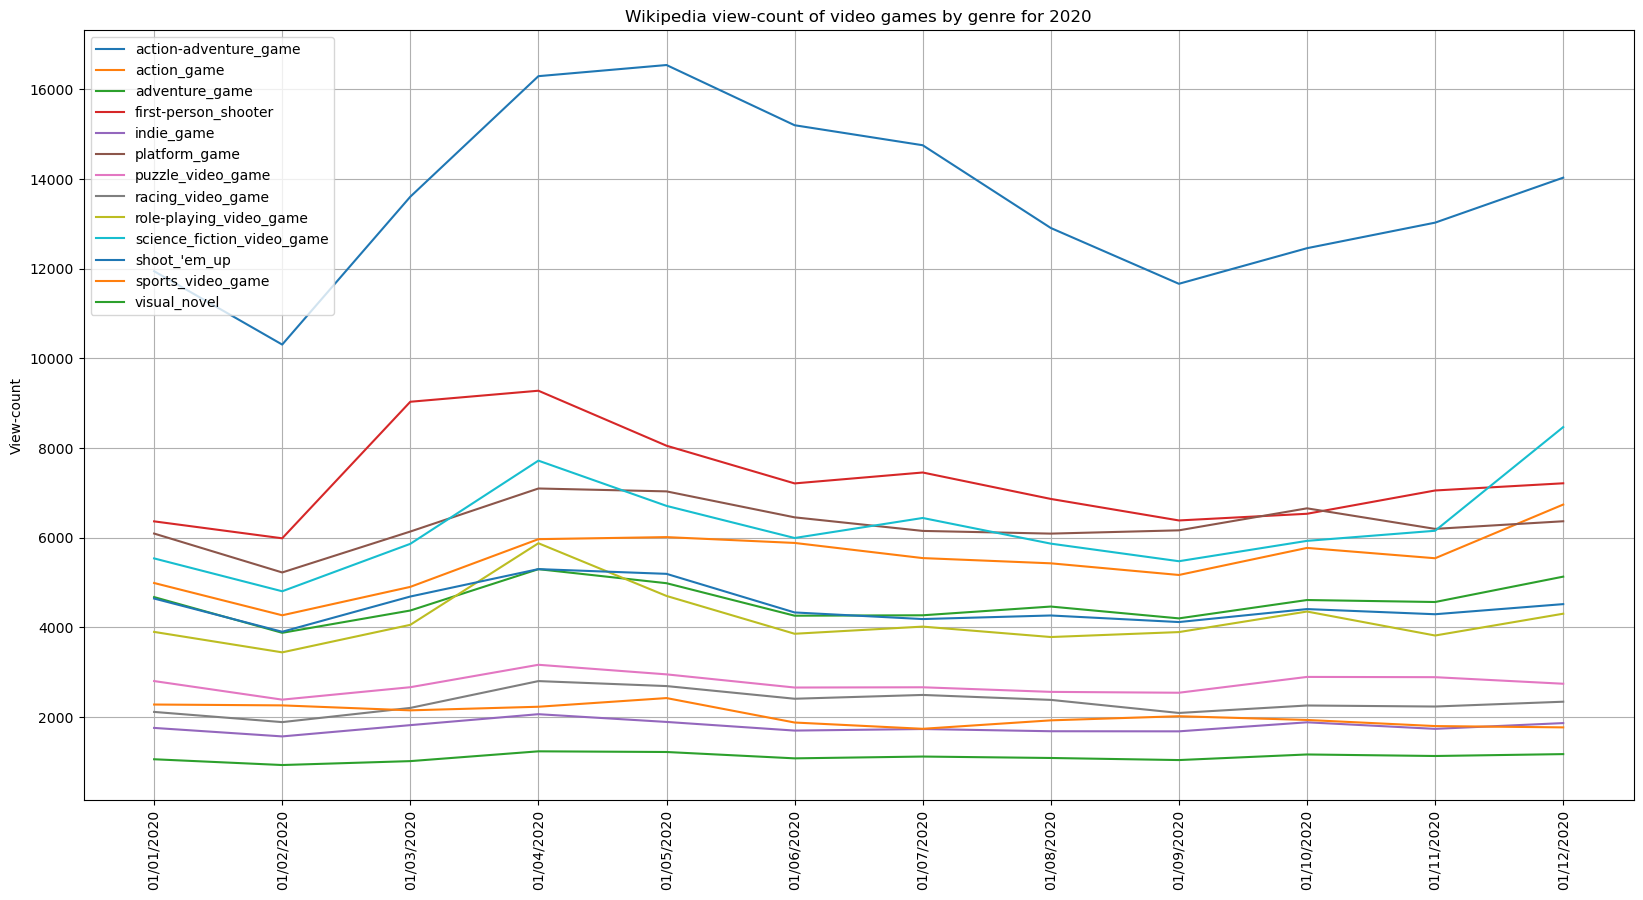

In [41]:
plt.figure(figsize=(20,10))

for g in count.index:
    plt.plot(dates, games_relative['{}'.format(g)], label='{}'.format(g))

plt.tick_params(axis='x', labelrotation=90)
plt.legend()
plt.grid()
plt.title("Wikipedia view-count of video games by genre for 2020")
plt.ylabel("View-count")
plt.xticks(dates, date)
plt.show()

In [42]:
games_relative=games_relative.drop(['Unnamed: 0'], axis=1)
games_relative['Total']=games_relative.sum(axis=1)
games_relative

,action-adventure_game,racing_video_game,action_game,platform_game,puzzle_video_game,shoot_'em_up,adventure_game,role-playing_video_game,science_fiction_video_game,first-person_shooter,sports_video_game,visual_novel,indie_game,Total
0,11942.273088,2114.606729,4989.505376,6092.052732,2802.646182,4643.014937,4675.296495,3898.906353,5537.770291,6363.956424,2279.416595,1059.101172,1757.989247,58156.535620
1,10306.212465,1887.334804,4269.512334,5224.532542,2388.648510,3902.061987,3878.816456,3442.998588,4805.055130,5986.232156,2260.509075,930.433683,1568.637419,50850.985149
2,13603.138810,2203.975731,4903.008539,6137.051781,2665.661546,4688.000747,4375.739046,4056.643765,5862.880551,9030.942149,2149.911841,1017.575571,1820.073333,62514.603409
3,16291.233428,2802.013238,5966.939279,7096.818052,3165.820298,5299.135922,5297.793574,5876.158588,7717.926493,9276.922615,2229.958513,1235.961752,2064.040645,74320.722397
4,16539.631161,2691.093767,6012.855787,7032.460808,2952.111266,5193.601942,4984.844206,4700.838588,6708.978560,8050.832457,2423.458946,1221.048735,1891.367527,70403.123752
5,15197.032861,2408.405957,5882.788741,6453.737767,2658.682030,4332.737117,4260.291139,3857.538353,5992.766462,7210.261458,1878.294728,1079.254781,1698.535699,62910.327094
6,14751.120113,2493.230006,5544.894054,6150.919715,2664.131750,4185.407767,4269.511198,4017.001882,6439.541348,7453.496619,1738.141746,1119.447872,1732.995484,62559.839554
7,12905.650992,2383.148373,5428.260278,6090.690261,2561.667598,4265.120239,4464.256573,3784.656000,5867.078867,6863.895567,1926.652550,1087.508328,1683.924946,59312.510571
8,11661.462323,2091.628240,5168.387097,6163.847031,2542.408287,4118.573562,4200.538462,3895.092235,5475.134763,6384.195342,2018.794296,1041.184454,1681.582581,56442.828672
9,12455.143909,2257.835632,5771.806768,6654.439905,2894.952514,4407.784914,4609.860273,4353.109647,5929.079632,6533.164538,1935.290406,1165.848242,1883.094194,60851.410574


In [70]:
y = np.zeros((len(dates),len(count.index)))

In [71]:
for i in range(len(dates)):
    for g in range(len(count.index)):
        y[i,g] = (games_relative['{}'.format(count.index[g])])[i]/games_relative.Total[i]
y

array([[0.20534705, 0.08579441, 0.08039159, 0.10942805, 0.03022858,
        0.10475268, 0.04819142, 0.0363606 , 0.06704159, 0.0952218 ,
        0.07983651, 0.0391945 , 0.01821121],
       [0.20267478, 0.08396125, 0.0762781 , 0.11772107, 0.03084773,
        0.10274201, 0.0469735 , 0.03711501, 0.06770761, 0.09449286,
        0.07673523, 0.04445359, 0.01829726],
       [0.21759938, 0.07842981, 0.06999547, 0.14446132, 0.02911437,
        0.09816989, 0.04264062, 0.03525537, 0.06489114, 0.09378418,
        0.07499049, 0.03439055, 0.01627741],
       [0.21920176, 0.08028635, 0.07128286, 0.12482283, 0.02777207,
        0.09548909, 0.04259674, 0.03770164, 0.07906487, 0.10384623,
        0.07130092, 0.03000453, 0.01663011],
       [0.23492752, 0.08540609, 0.0708043 , 0.11435334, 0.02686482,
        0.09988848, 0.04193154, 0.03822407, 0.06677031, 0.09529376,
        0.07376948, 0.03442261, 0.01734367],
       [0.24156658, 0.0935107 , 0.06772006, 0.11461173, 0.02699931,
        0.1025863 , 0.04226

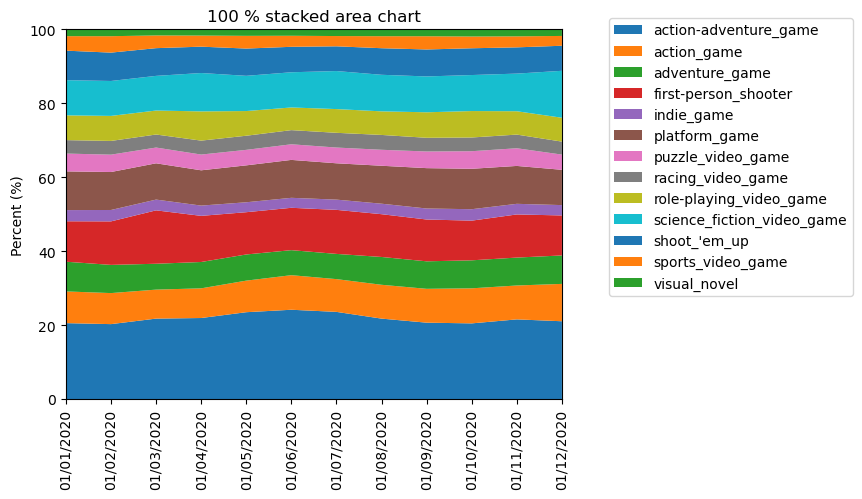

In [80]:
x = dates

fig = plt.figure()
ax = fig.add_subplot(111)

ax.stackplot(x, y.transpose()*100)
ax.set_title('100 % stacked area chart')
ax.set_ylabel('Percent (%)')
ax.legend(count.index,bbox_to_anchor=(1.6, 1.05))
ax.margins(0, 0) # Set margins to avoid "whitespace"
plt.tick_params(axis='x', labelrotation=90)
plt.xticks(dates, date)
plt.show()

# The next steps
These are obviously only preliminary analysis, what we would like to do next is to also extract 2019 values in order to compute a baseline. That way we would be able to compare the trends pre- and post-pandemic. Then, we also want to analyze other types of entertainment like books, films, music, [...] using a similar method. A key aspect is also the language; here we only analyzed english, but we will also take a look other languages. This will allow us to compare trends with the available mobility reports.